### Загрузка и преобразование данных

In [2]:
!pip install pyrsgis
!pip install rioxarray
!pip install earthpy
!pip install dbfread
!pip install -U scikit-learn
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
/bin/bash: строка 1: pip install graphviz: команда не найдена


In [3]:
from pyrsgis import raster
from PIL import Image, ImageDraw
import numpy as np
import cv2
import math
import os
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from matplotlib.colors import ListedColormap
from earthpy.mask import mask_pixels
from dbfread import DBF
import random

In [4]:
ds4, croptypes = raster.read("Croptypes.tif", bands ='all')

In [5]:
croptypes.shape

(2644, 2891)

In [6]:
features = []
for i in range(7):
    name = "Band0" + str(i + 1) + ".tif"
    _, f = raster.read(name)
    features.append(f)

_, f = raster.read("Band10.tif")
features.append(f)
_, f = raster.read("ndvi_sample.tif")
features.append(f)
features = np.array(features)

In [7]:
features.shape

(9, 2644, 2891)

### Масштабирование признаков
Необходимо для простой работы с формулой для уменьшения изображений
#### Вопрос:
Что делать со среднеквадратическим? Брать просто значение каждого пикселя по модулю, или же рассчитать его относительно всех матриц-признаков не по отдельности, а вместе 

In [8]:
for i in range(len(features)):
    features[i] = features[i] / np.max(features[i])

In [9]:
ground_truth = np.array(croptypes == 36)

### Визуализация

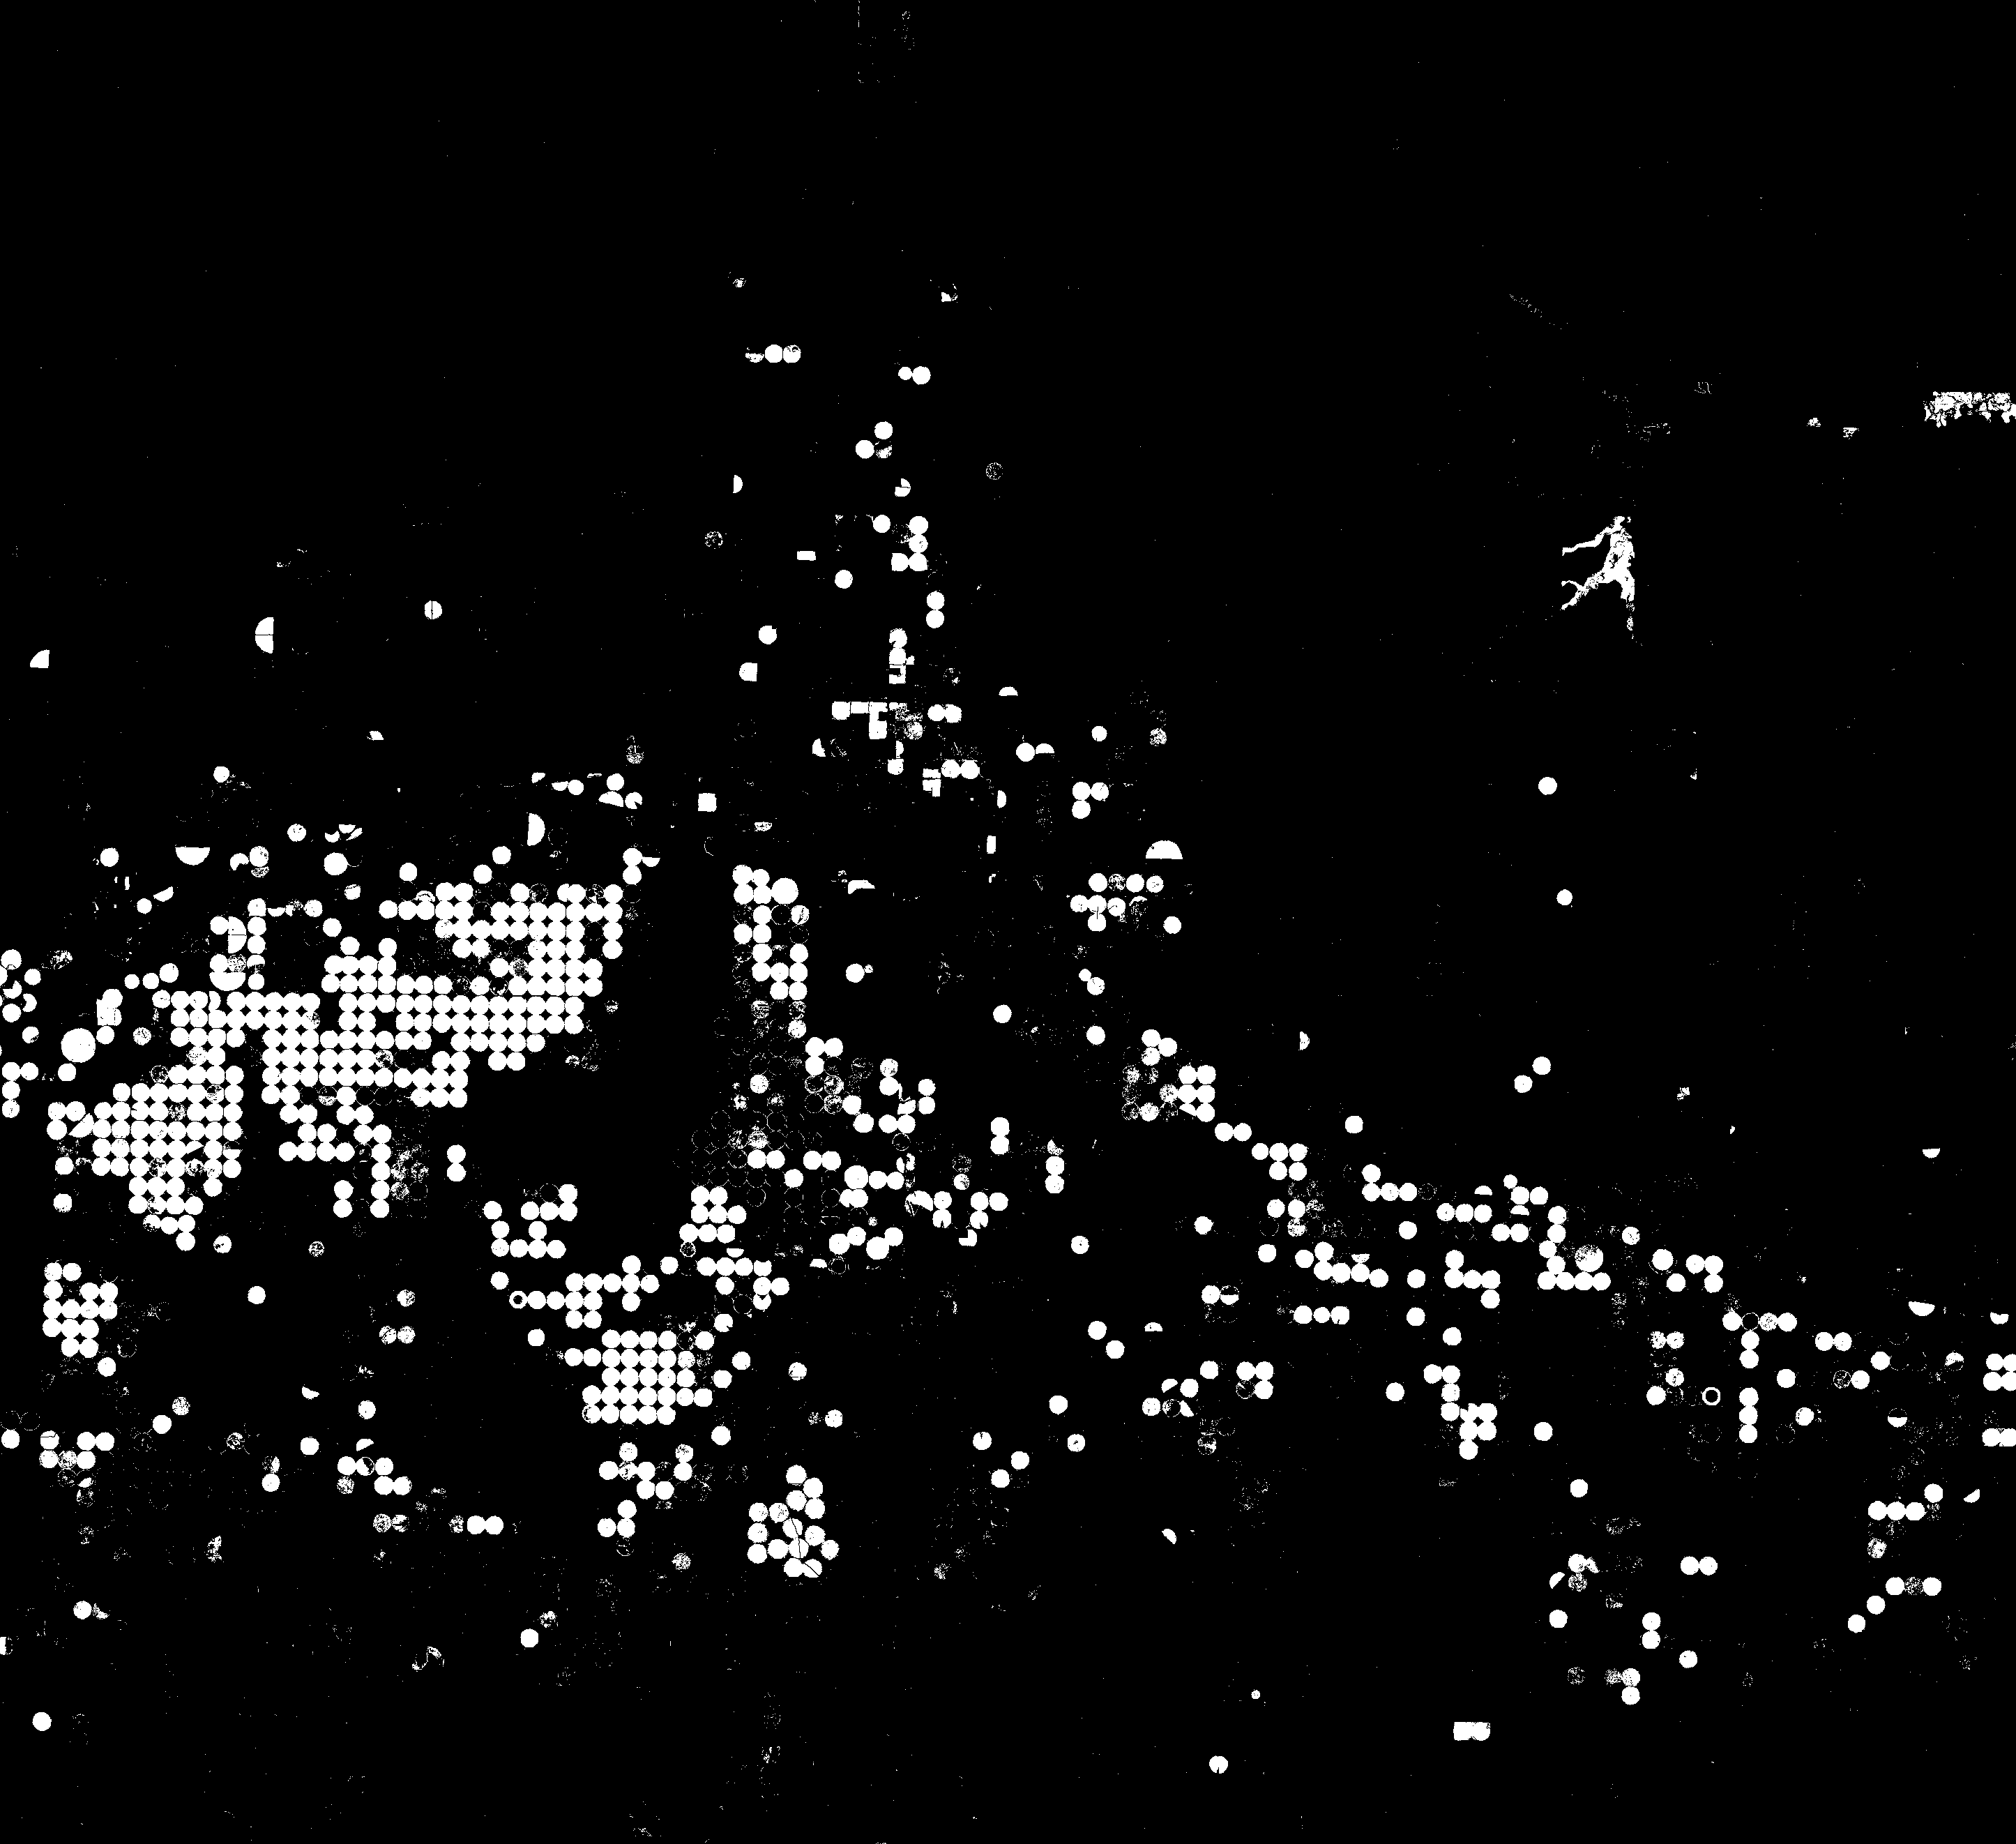

In [10]:
Image.fromarray(ground_truth)

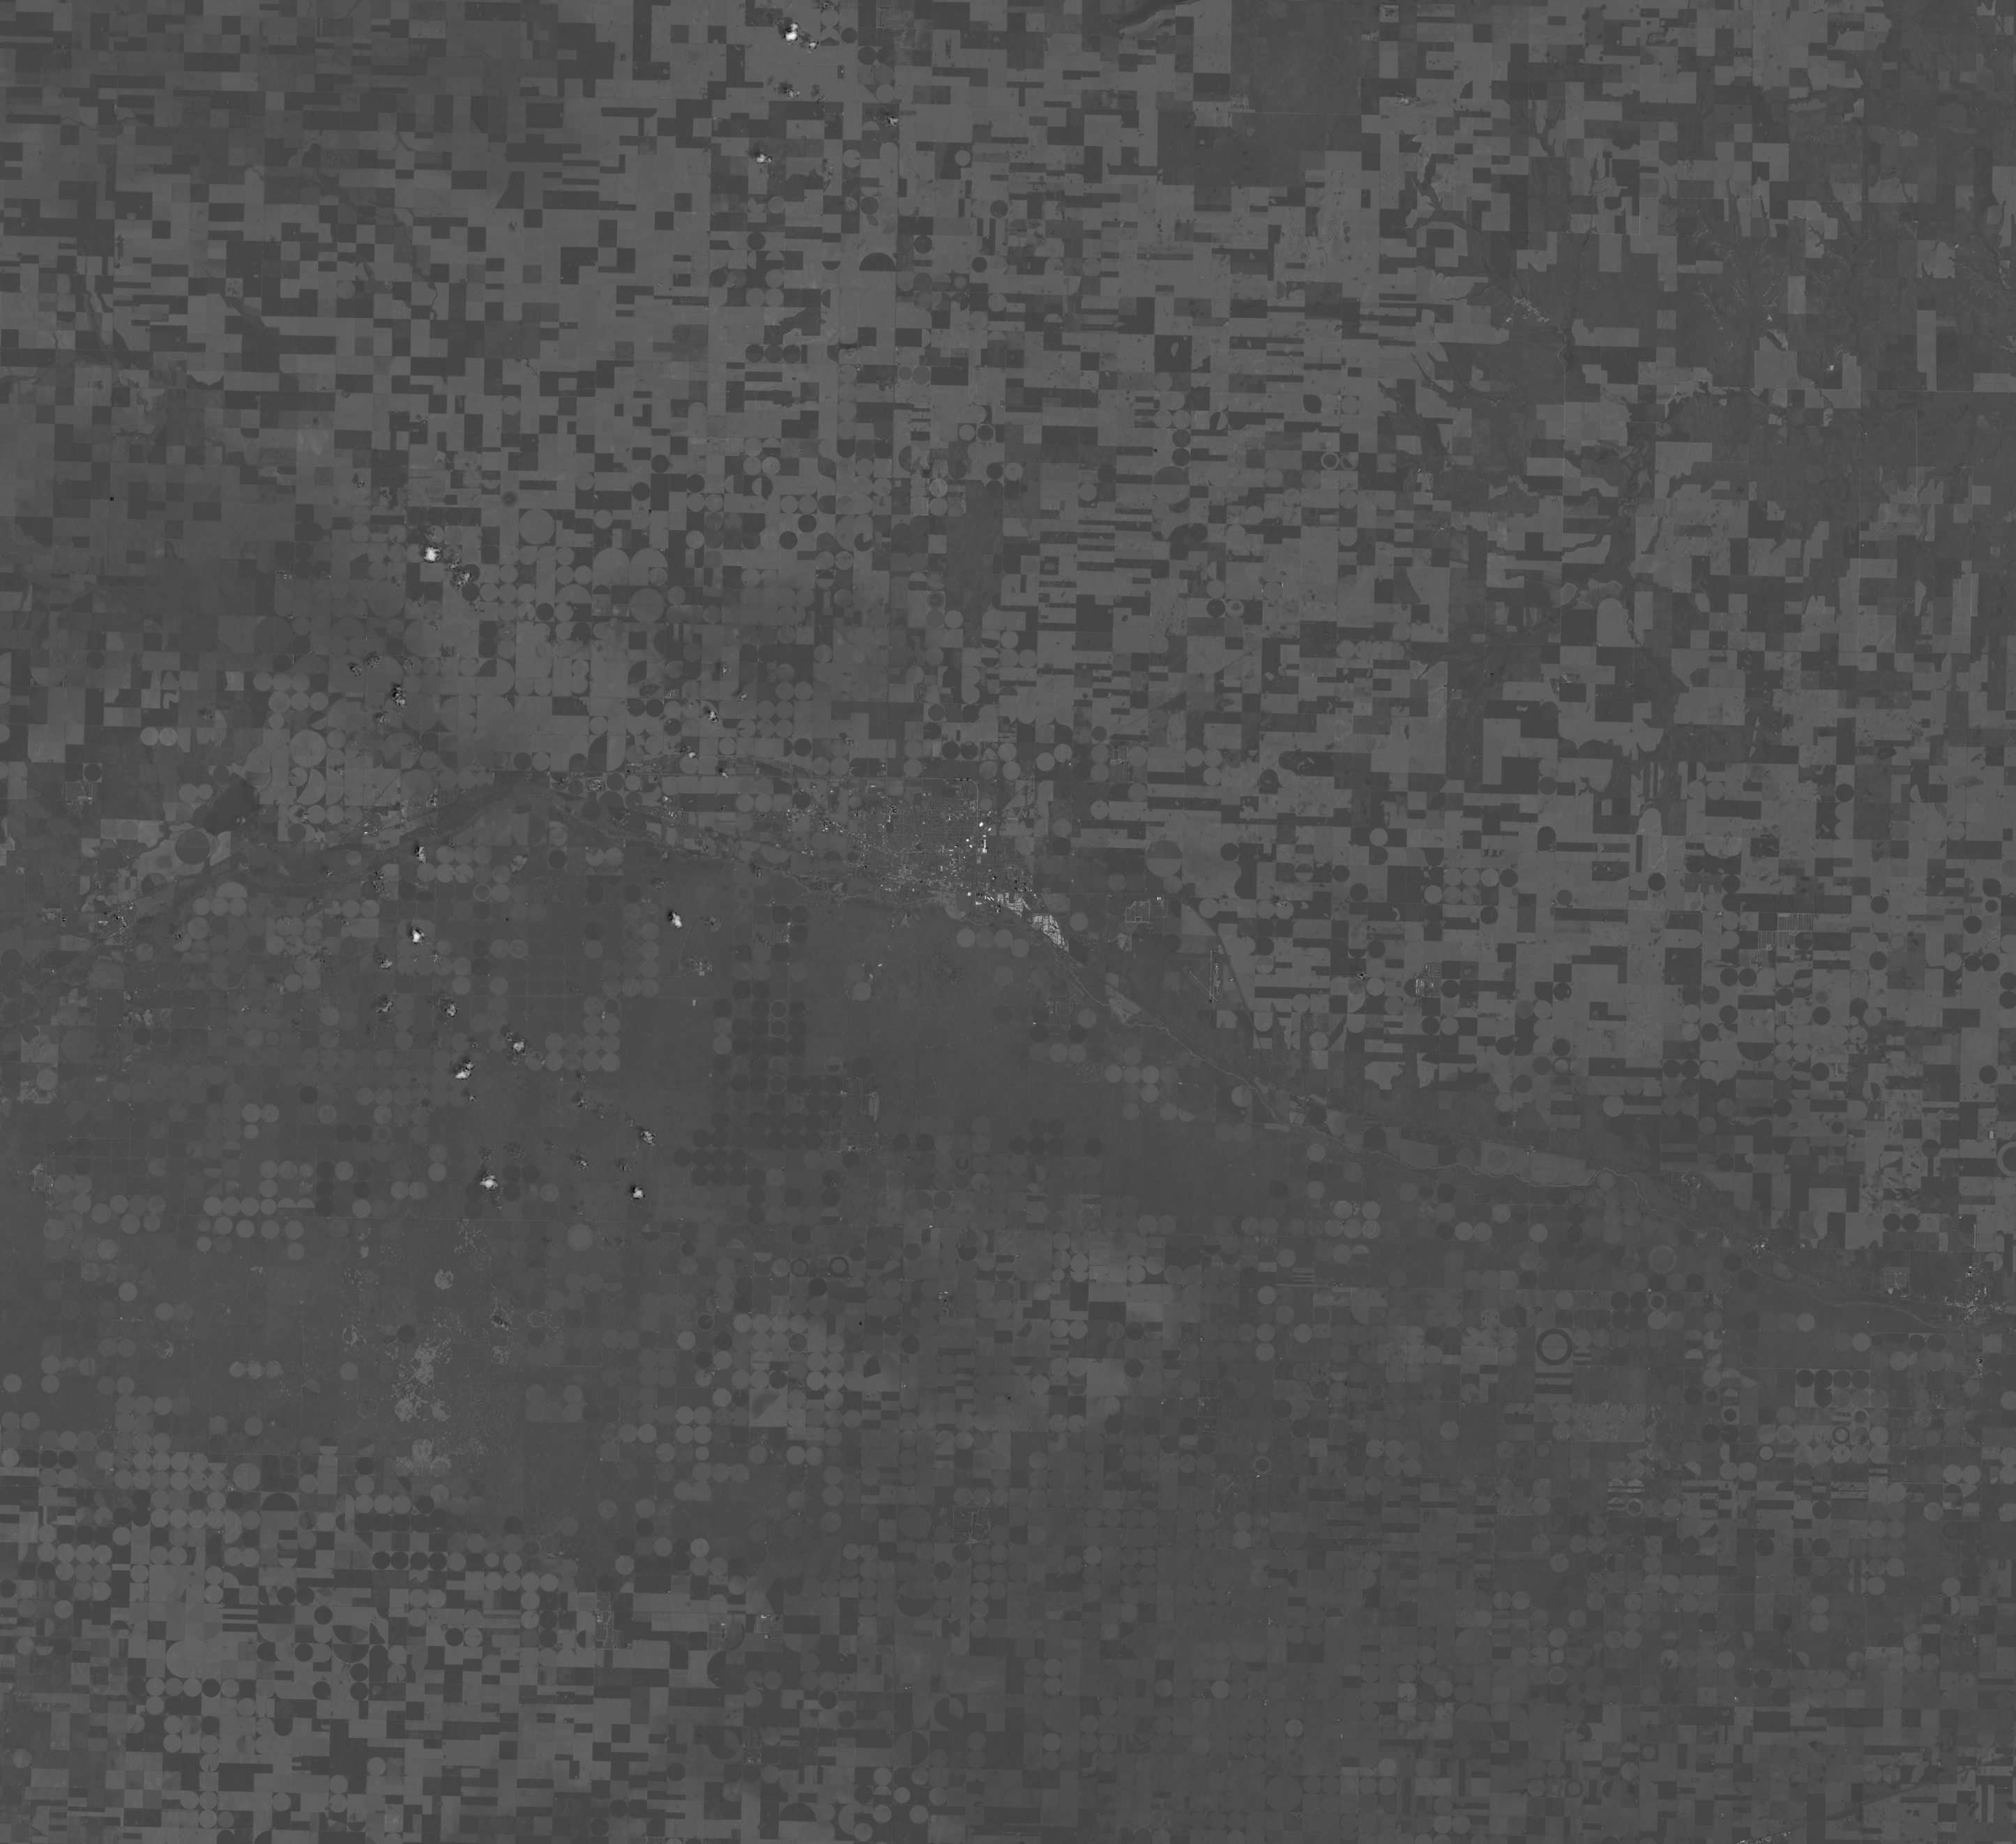

In [11]:
Image.fromarray(np.array(features[0] * 255).astype("uint8").clip(0, 255))

## Уменьшение изображения

In [12]:
# Функция для свертки со страйдом
def convolutionFilter(data_array, kernel, stride):
  image = np.array(data_array).astype(float)
  w, h = image.shape
  d = kernel.shape[0]
  nw = (w - d) // stride + 1
  nh = (h - d) // stride + 1
  n_img = np.empty([nw, nh])
  for i in range(nw):
    for j in range(nh):
      pixel = 0
      for k in range(d):
        for q in range(d):
          pixel += kernel[k][q] * image[i*stride+k][j*stride+q]
      n_img[i][j] = pixel
  return n_img

In [13]:
# Функция для уменьшения изображения. 
# la - параметр лямбда 
# d - во сколько раз уменьшаем (целое число)
# data_array - numpy массив с данными
def detailedDownscale(data_array, d, la):
    data_array = np.array(data_array).astype(float)
    w, h = data_array.shape
    kernel = np.ones([d, d]) / (d * d)
    downscaled = convolutionFilter(data_array, kernel, d)
    print("resized")
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    im_tilde = convolutionFilter(downscaled, kernel, 1)
    print("im_tilde done")
    w_o, h_o = im_tilde.shape
    output = np.empty([w_o, h_o])
    for i in range(w_o):
        for j in range(h_o):
            k_p = 0
            output[i][j] = 0
            I_p = im_tilde[i][j]
            num = 0
            for k in range(d):
                for q in range(d):
                    num = data_array[i*d + k][j*d + q] - I_p + 1e-8
                    num = abs(num) # среднеквадратическое
                    num = math.pow(num, la)
                    k_p += num
                    output[i][j] += data_array[i*d + k][j*d + q] * num
            output[i][j] /= k_p
    return output

In [14]:
data = detailedDownscale(ground_truth.astype(float), 4, 0.3)
data = data.round()
data = data.astype(bool)
Image.fromarray(data)

resized
im_tilde done


KeyboardInterrupt: 

#### Вопрос:
Для более-менее корректного сравнения пространственного дерева, использующего уменьшенные изображения вместо обычных, и такого, которое использует обычные, скорее всего, придется что-то сделать с алгоритмом уменьшения, на Python он тоже работает довольно медленно (но терпимо), тогда как следует поступить в будущем - учитывать ли его время выполнения как часть времени выполнения нашего "нового" дерева или нет, и если да, то что с ним делать, как оптимизировать (возможно переписать на другом языке и т д), или, возможно, сравнивать не настоящее время выполнения, а посчитать теоретическое

In [ ]:
n_features = []
for f in features:
    print("Processing...")
    n_features.append(detailedDownscale(f, 4, 0.3))
n_features = np.array(n_features).astype(float)

### Сравнение деревьев (недоделано)
#### Обучение дерева на уменьшенных данных и обычных
Уменьшенные данные обладают информацией о "пространственном" отношении каждой величины друг с другом, в отличие от неизменённых (для обычных, не учитывающих пространственные данные, деревьев)

In [ ]:
from sklearn import tree
X = []
Y = data
new_shape = data.shape[0] * data.shape[1]
Y = Y.reshape(new_shape)
for i in range(9):
    X.append(n_features[i].reshape(new_shape))
X = np.array(X).transpose()

#### Вопрос: нужно ли что-то делать с дисбалансом классов?

In [ ]:
_, counts = np.unique(Y, return_counts=True)
counts[1] / (counts[0]+counts[1]) # Дисбаланс классов (Нужно ли с ним что-то делать?)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
decision_tree = tree.DecisionTreeClassifier(max_depth=6)
decision_tree.fit(X_train, y_train)

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(decision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

In [ ]:
from sklearn.metrics import recall_score, precision_score
recall_score(y_test, decision_tree.predict(X_test))

In [ ]:
precision_score(y_test, decision_tree.predict(X_test))

In [ ]:
X = []
new_shape = ground_truth.shape[0] * ground_truth.shape[1]
for i in range(9):
    X.append(features[i].reshape(new_shape))
X = np.array(X).transpose()
y_pred = decision_tree.predict(X)
w, h = ground_truth.shape
predicted = y_pred.reshape(w, h)
Image.fromarray(predicted)

In [40]:
class Node:
    def __init__(self, n_matrix=None, threshold=None, feature_number=None, is_leaf=False, verdict=False):
        self.n_matrix = n_matrix  # если понадобится для анализа дерева
        self.threshold = threshold
        self.feature_number = feature_number
        self.is_leaf = is_leaf
        self.verdict = verdict
        self.left_node = None
        self.right_node = None


class SDTree:
    def __init__(self):
        self.__root = None

    def fit(self, x, y, alpha=0.5, min_node_size=50):
        w, h = y.shape
        neighbourhood_graph = np.ones([w, h])
        self.__root = self.__get_root(neighbourhood_graph, x, y, alpha, min_node_size, neighbourhood_graph.sum() + 1)

    def predict(self, x):
        w, h = x[0].shape
        y_pred = np.zeros([w, h])
        for i in range(w):
            for j in range(h):
                current_node = self.__root
                while not current_node.is_leaf:
                    if x[current_node.feature_number][i][j] <= current_node.threshold:
                        current_node = current_node.left_node
                    else:
                        current_node = current_node.right_node
                y_pred[i][j] = current_node.verdict
        return y_pred

    def __get_root(self, neighbourhood_graph, x, y, alpha, min_node_size, prev_size):
        if (neighbourhood_graph.sum() < min_node_size or
                self.__is_homogeneous(neighbourhood_graph, y) or
                neighbourhood_graph.sum() == prev_size):
            total_sum = neighbourhood_graph.sum()
            verdict = ((neighbourhood_graph * y).sum() / total_sum) >= 0.5
            print("Leaf created! Quantities: ",
                  neighbourhood_graph.sum() - (neighbourhood_graph * y).sum(),
                  " ",
                  (neighbourhood_graph * y).sum())
            return Node(neighbourhood_graph, is_leaf=True, verdict=verdict)
        best_feature_number = None
        best_threshold = None
        best_sig = None
        best_graph_1 = None
        best_graph_2 = None
        for i in range(len(x)):
            feature_matrix = x[i]
            unique_size = min(feature_matrix.size, 25)
            feature_values = np.random.choice(np.unique(feature_matrix.flatten()), unique_size)
            for feature_value in feature_values[:-1]:
                graph_1, graph_2 = self.__split(feature_value, neighbourhood_graph, feature_matrix)
                inf_gain = self.__calculate_information_gain(graph_1, graph_2, y)
                nsar = self.__calculate_nsar(neighbourhood_graph, graph_1, graph_2, y)
                spatial_inf_gain = (1 - alpha) * inf_gain + alpha * nsar
                if (best_sig is None) or (spatial_inf_gain > best_sig):
                    best_sig = spatial_inf_gain
                    best_feature_number = i
                    best_threshold = feature_value
                    best_graph_1 = graph_1
                    best_graph_2 = graph_2
        current_node = Node(neighbourhood_graph, best_threshold, best_feature_number)
        print("Node created! Feature: ", 
              best_feature_number, 
              ", threshold: ", 
              best_threshold, 
              ", size: ", 
              neighbourhood_graph.sum())
        prev_size = neighbourhood_graph.sum()
        current_node.left_node = self.__get_root(best_graph_1, x, y, alpha, min_node_size, prev_size)
        current_node.right_node = self.__get_root(best_graph_2, x, y, alpha, min_node_size, prev_size)
        return current_node

    def __calculate_nsar(self, neighbourhood_graph, graph_1, graph_2, y):
        gamma_before = self.__calculate_gamma_sum(neighbourhood_graph, y)
        gamma_after = self.__calculate_gamma_sum(graph_1, y)
        zeros_matrix = (gamma_before == 0).astype(float)
        gamma_after = gamma_after * (zeros_matrix == 0) + zeros_matrix
        gamma_before = gamma_before * (zeros_matrix == 0) + zeros_matrix
        return (gamma_after / gamma_before).mean()

    @staticmethod
    def __calculate_gamma_sum(neighbourhood_graph, y):
        labels_matrix = y * neighbourhood_graph - (neighbourhood_graph != 1)
        right_neighbors = np.concatenate(
            (labels_matrix[:, 1:], -1 * np.ones([labels_matrix.shape[0], 1])),
            axis=1)
        gamma_sum = (labels_matrix == right_neighbors).astype(float)
        left_neighbors = np.concatenate(
            (-1 * np.ones([labels_matrix.shape[0], 1]), labels_matrix[:, :-1]),
            axis=1)
        gamma_sum += (labels_matrix == left_neighbors).astype(float)
        top_neighbors = np.concatenate(
            (-1 * np.ones([1, labels_matrix.shape[1]]), labels_matrix[:-1, :]),
            axis=0)
        gamma_sum += (labels_matrix == top_neighbors).astype(float)
        bottom_neighbors = np.concatenate(
            (labels_matrix[1:, :], -1 * np.ones([1, labels_matrix.shape[1]])),
            axis=0)
        gamma_sum += (labels_matrix == bottom_neighbors).astype(float)
        gamma_sum *= neighbourhood_graph
        return gamma_sum

    @staticmethod
    def __calculate_information_gain(split_1, split_2, y):
        n_1 = split_1.sum()
        p_true = 0 if n_1 == 0 else (split_1 * y).sum() / n_1
        entropy_1 = 0 if (p_true == 0 or p_true == 1) \
            else -p_true * np.log2(p_true) - (1 - p_true) * np.log2(1 - p_true)
        n_2 = split_2.sum()
        p_true = 0 if n_2 == 0 else (split_2 * y).sum() / n_2
        entropy_2 = 0 if (p_true == 0 or p_true == 1) \
            else -p_true * np.log2(p_true) - (1 - p_true) * np.log2(1 - p_true)
        entropy_after_split = 0 if (n_1 == 0 and n_2 == 0) \
            else (n_1 * entropy_1 + n_2 * entropy_2) / (n_1 + n_2)
        entire_graph = split_1 + split_2
        n = entire_graph.sum()
        p_true = 0 if n == 0 else (entire_graph * y).sum() / n
        entropy_before_split = 0 if (p_true == 0 or p_true == 1) \
            else -p_true * np.log2(p_true) - (1 - p_true) * np.log2(1 - p_true)
        return entropy_before_split - entropy_after_split

    @staticmethod
    def __split(threshold, graph, feature_matrix):
        w, h = graph.shape
        below_threshold = np.zeros([w, h])
        above_threshold = np.zeros([w, h])
        for i in range(w):
            below_threshold[i] += (feature_matrix[i] <= threshold) * graph[i]
            above_threshold[i] += (feature_matrix[i] > threshold) * graph[i]
        return [below_threshold, above_threshold]

    @staticmethod
    def __is_homogeneous(graph, y):
        graph_sum = graph.sum()
        union_sum = (graph * y).sum()
        if (union_sum == 0) or (graph_sum == union_sum):
            return True
        return False

In [20]:
def example_first():
    tree = SDTree()
    y = np.zeros([8, 8])
    for i in range(4):
        for j in range(8):
            y[i][j] = 1
    f_1 = np.ones([8, 8]) * 10
    f_2 = np.ones([8, 8]) * 10
    f_1[0:4, 0:8] *= 3
    f_1[1, 1] = 10
    f_1[1, 5] = 10
    f_1[3, 1] = 10
    f_1[1, 5] = 10
    f_1[5, 1] = 30
    f_1[5, 5] = 30
    f_1[5, 7] = 30
    f_1[7, 2] = 30
    f_1[7, 5] = 30
    f_2[4:8, 0:8] = 20
    f_2[0:4, 2:6] = 30
    x = np.array([f_1, f_2])
    print("TRAIN USING SIG")
    tree.fit(x, y, alpha=0.5, min_node_size=4)
    print("TRAIN USING IG")
    tree_1 = SDTree()
    tree_1.fit(x, y, alpha=0, min_node_size=4)
    y_pred = tree.predict(x)
    print("Features:\nFeature 0:\n", f_1, "\nFeature 1:\n", f_2, "\nGround truth:\n", y)
    print("Prediction with SIG:\n", y_pred)
    print("Prediction with IG:\n", tree_1.predict(x))

In [21]:
def example_second():
    y = np.ones([4, 8])
    y[0:4, 0:4] = 0
    f_1 = np.ones([4, 8]) * 10
    f_1[0:4, 0:4] *= 3
    f_1[1, 1] = 10
    f_1[3, 1] = 10
    f_1[1, 5] = 30
    f_1[1, 7] = 30
    f_1[3, 5] = 30
    f_2 = np.ones([4, 8]) * 10
    f_2[0:4, 4:8] *= 2
    f_2[0:4, 2:4] *= 3
    tree = SDTree()
    x = np.array([f_1, f_2])
    print("TRAIN USING SIG")
    tree.fit(x, y, alpha=0.5, min_node_size=4)
    print("TRAIN USING IG")
    tree_1 = SDTree()
    tree_1.fit(x, y, alpha=0, min_node_size=4)
    y_pred = tree.predict(x)
    print("Features:\nFeature 0:\n", f_1, "\nFeature 1:\n", f_2, "\nGround truth:\n", y)
    print("Prediction with SIG:\n", y_pred)
    print("Prediction with IG:\n", tree_1.predict(x))

In [29]:
print("First example:")
example_first()
print("Second example:")
example_second()

First example:
TRAIN USING SIG
Entering feature:  0
Entering feature:  1
Node created! Feature:  1 , threshold:  20.0
Entering feature:  0
Entering feature:  1
Node created! Feature:  1 , threshold:  10.0
Leaf created! Quantities:  0.0   16.0
Leaf created! Quantities:  32.0   0.0
Leaf created! Quantities:  0.0   16.0
TRAIN USING IG
Entering feature:  0
Entering feature:  1
Node created! Feature:  0 , threshold:  10.0
Entering feature:  0
Entering feature:  1
Node created! Feature:  1 , threshold:  10.0
Leaf created! Quantities:  0.0   2.0
Entering feature:  0
Entering feature:  1
Node created! Feature:  1 , threshold:  20.0
Leaf created! Quantities:  27.0   0.0
Leaf created! Quantities:  0.0   1.0
Entering feature:  0
Entering feature:  1
Node created! Feature:  1 , threshold:  20.0
Entering feature:  0
Entering feature:  1
Node created! Feature:  1 , threshold:  10.0
Leaf created! Quantities:  0.0   14.0
Leaf created! Quantities:  5.0   0.0
Leaf created! Quantities:  0.0   15.0
Featur

In [23]:
n_features = []
for f in features:
    print("Processing...")
    n_features.append(detailedDownscale(f, 6, 0.3))
n_features = np.array(n_features).astype(float)
data = detailedDownscale(ground_truth.astype(float), 6, 0.3)
data = data.round()
data = data.astype(bool)

Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
Processing...
resized
im_tilde done
resized
im_tilde done


In [24]:
print(n_features.shape)
print(data.shape)

(9, 438, 479)
(438, 479)


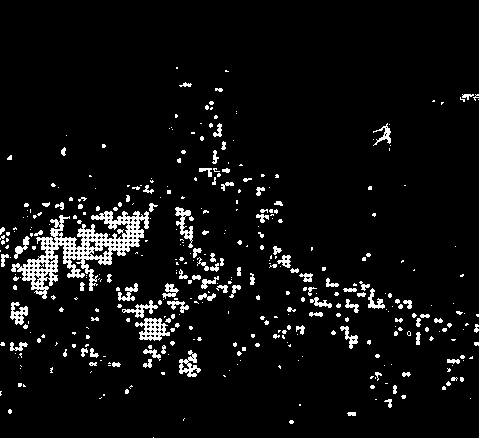

In [25]:
Image.fromarray(data)

In [41]:
sdtree = SDTree()
sdtree.fit(n_features, data, min_node_size = 1500)

Node created! Feature:  4 , threshold:  0.675967331287466 , size:  209802.0
Node created! Feature:  4 , threshold:  0.6763585883560229 , size:  204795.0
Leaf created! Quantities:  196737.0   8058.0
Leaf created! Quantities:  0.0   0.0
Node created! Feature:  0 , threshold:  0.2789390230759927 , size:  5007.0
Leaf created! Quantities:  865.0   103.0
Node created! Feature:  0 , threshold:  0.2856522801383932 , size:  4039.0
Leaf created! Quantities:  136.0   45.0
Node created! Feature:  2 , threshold:  0.30472969589017035 , size:  3858.0
Node created! Feature:  5 , threshold:  0.2991329919361154 , size:  3687.0
Leaf created! Quantities:  64.0   20.0
Node created! Feature:  2 , threshold:  0.2952402219273968 , size:  3603.0
Node created! Feature:  3 , threshold:  0.2505668767546581 , size:  3436.0
Node created! Feature:  2 , threshold:  0.2901321061952424 , size:  3277.0
Node created! Feature:  5 , threshold:  0.30700810963550884 , size:  3182.0
Leaf created! Quantities:  22.0   154.0
Nod

In [42]:
y_pred = sdtree.predict(features)

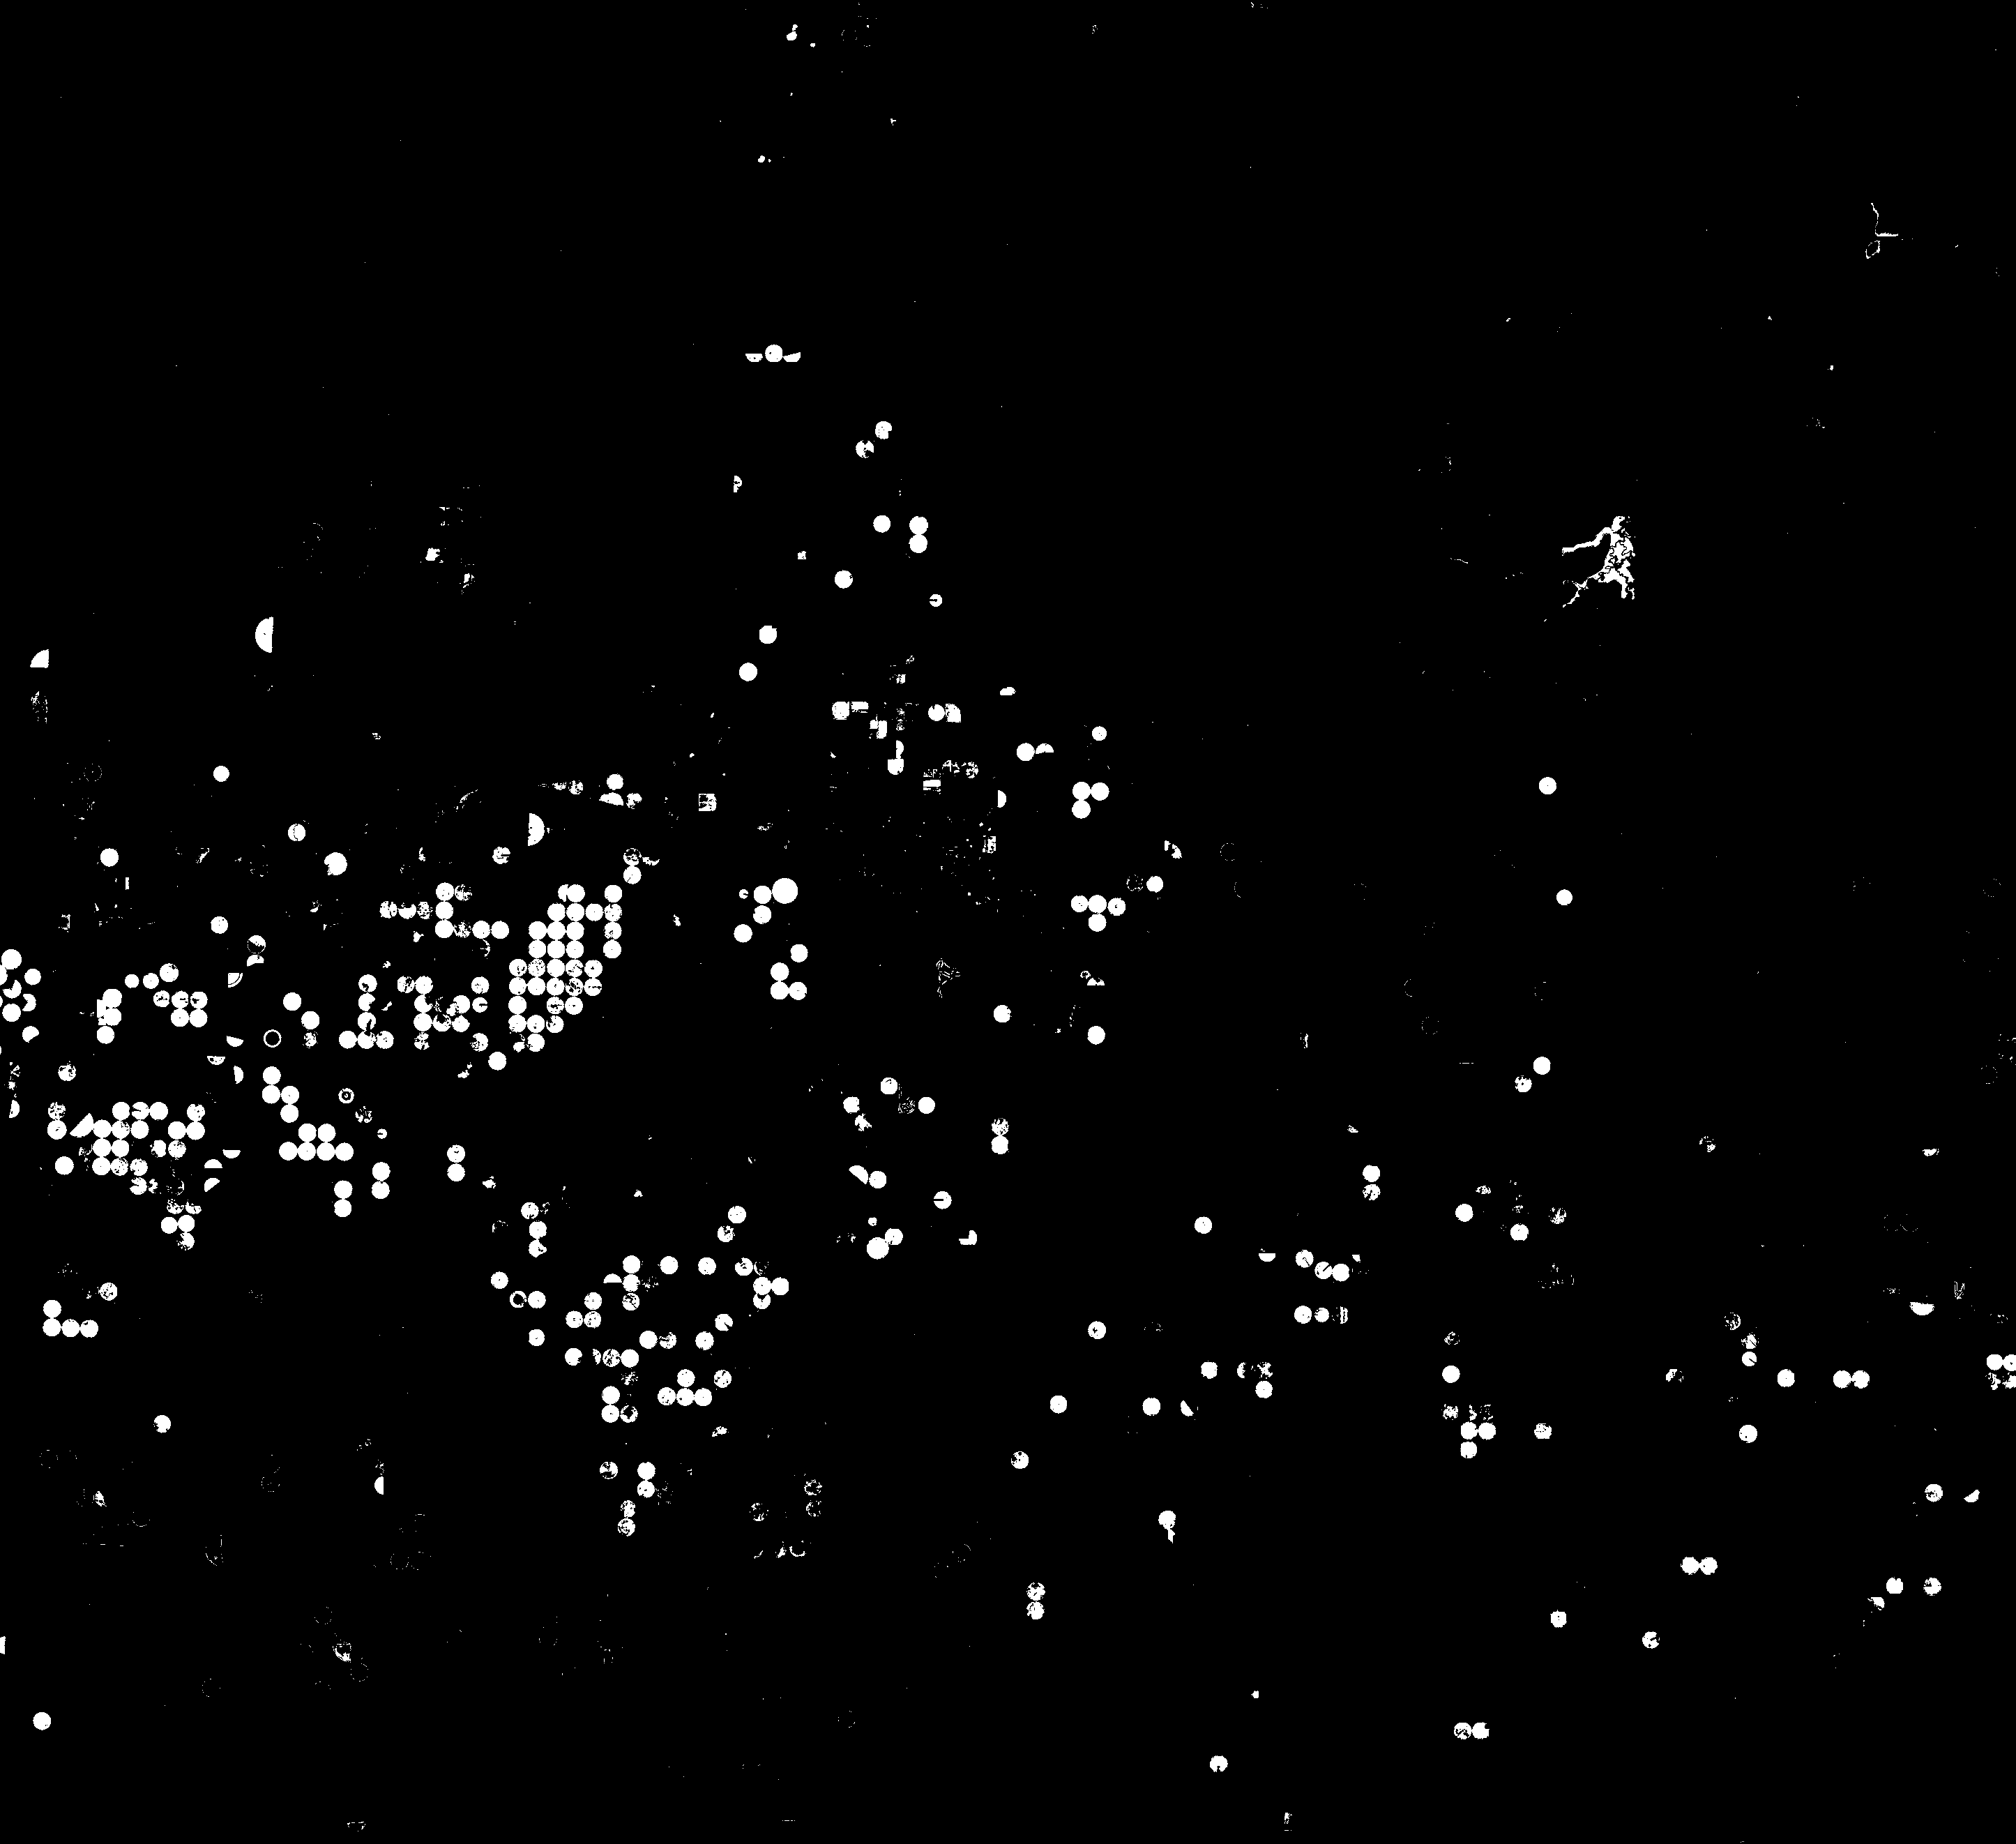

In [47]:
Image.fromarray(y_pred.astype(bool))